# **Extraction of static data for feature set 1**

Two models will be trained for each set of features derived from literature and clinical availability.

Each will be trained on first just the dynamic features and then both the static and dynamic features.

Through this we can see whether consideration of static features imporves the model's predictive capability.

The static data will be processed through a feedforward loop (https://arxiv.org/pdf/1602.02685) and the outputs of the network are concatenated and fed into a final layer to make predictions.

The static features for feature set 1 are defined to be popular in literature and clinically relevant.

Static features are not specifically mentioned in the WAVE data used as clinical proxy but upon discussion with Mr Murali, the features that were most popular in literature and also widely recorded in clinical practice are taken to be the static features for feature set 1.

These are:

- Age
- Gender
- BMI
- Weight
- Height
- Ethnicity

https://medium.com/omdena/time-series-classification-tutorial-combining-static-and-sequential-feature-modeling-using-ac18fe85c92c


BMI, Height and Weight are taken as time series data from chartevents. Since this data is being treated as static, the Height, Weight and hence BMI of the patient will be taken at the closest point possible to the start of the 6 hour time window prior to extubation and made constant throughout the window.

Age, Gender and Ethnicity will be extracted from patients and admissions tables and kept constant throughout.

Gender and Ethnicity will be categorical values that will need to be one-hot encoded into numerical format.

Age, BMI< Weight and Height will be treated as a numerical feature as per (https://arxiv.org/pdf/1602.02685), and thus normalised.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

Load the train and test data prior to sequence creation.

In [ ]:
train_data = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/02_feature_subsets/run_2/03_low_df_train_scaled.parquet'
test_data = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/02_feature_subsets/run_2/03_low_df_test_scaled.parquet'

train_df = pd.read_parquet(train_data)
test_df = pd.read_parquet(test_data)

train_df.head()

,time_from_window_start_mins,subject_id,feature_label,valuenum,extubation_failure
0,0 days 00:00:00,10001884,PH (Arterial),NaN,1.0
1,0 days 02:00:00,10001884,PH (Arterial),NaN,1.0
2,0 days 04:00:00,10001884,PH (Arterial),NaN,1.0
3,0 days 06:00:00,10001884,PH (Arterial),NaN,1.0
4,0 days 00:00:00,10001884,Arterial CO2 Pressure,NaN,1.0


In [ ]:
# Check the number of subject ids in each
train_df['subject_id'].nunique(), test_df['subject_id'].nunique()

(3760, 941)

Extract the static features for all patients in the defined population.

**Age - from patients file**

In [ ]:
# Load the patients file from MIMIC
patients = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/mimic-iv-2.2-raw-data/hosp/patients.csv'
patients_df = pd.read_csv(patients)
patients_df.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


In [ ]:
# Extract the unique subject ids from the train and test sets
train_subject_ids = train_df['subject_id'].unique()
test_subject_ids = test_df['subject_id'].unique()

train_subject_ids.shape, test_subject_ids.shape

((3760,), (941,))

In [ ]:
# For each subject id in the train and test set, extract into a dataframe the anchor_age from patients_df
train_anchor_age = patients_df[patients_df['subject_id'].isin(train_subject_ids)][['subject_id', 'anchor_age']]

test_anchor_age = patients_df[patients_df['subject_id'].isin(test_subject_ids)][['subject_id', 'anchor_age']]

train_anchor_age.head(), test_anchor_age.head()

(     subject_id  anchor_age
 61     10001884          68
 76     10002428          80
 129    10004235          47
 335    10010867          28
 351    10011365          73,
      subject_id  anchor_age
 147    10004720          61
 148    10004733          51
 191    10005817          66
 407    10013643          79
 697    10022620          34)

**Gender**

From patients file

In [ ]:
# Add the gender of each patient from the patients_df
train_gender = patients_df[patients_df['subject_id'].isin(train_subject_ids)][['subject_id', 'gender']]

test_gender = patients_df[patients_df['subject_id'].isin(test_subject_ids)][['subject_id', 'gender']]

train_gender.shape, test_gender.shape

((3760, 2), (941, 2))

In [ ]:
# Join age and gender into one dataframe
train_static = train_anchor_age.merge(train_gender, on='subject_id', how='left')

test_static = test_anchor_age.merge(test_gender, on='subject_id', how='left')

train_static.head()

,subject_id,anchor_age,gender
0,10001884,68,F
1,10002428,80,F
2,10004235,47,M
3,10010867,28,F
4,10011365,73,F


**Ethnicity**

From admissions

In [ ]:
# Load admissions file from MIMIC
admissions = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/mimic-iv-2.2-raw-data/hosp/admissions.csv'
admissions_df = pd.read_csv(admissions)
admissions_df.tail()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
431226,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,P75BG6,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0
431227,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,NaN,EW EMER.,P16C7J,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,2147-07-17 17:18:00,2147-07-18 17:34:00,0
431228,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,EW EMER.,P58A9J,EMERGENCY ROOM,DIED,Other,ENGLISH,WIDOWED,WHITE,2164-09-10 11:09:00,2164-09-10 14:46:00,1
431229,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00,NaN,EW EMER.,P506DE,EMERGENCY ROOM,HOME,Other,ENGLISH,WIDOWED,WHITE,2164-07-24 21:16:00,2164-07-25 01:20:00,0
431230,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0


In [ ]:
# Extract the unique race from admissions
ethnicities = admissions_df['race'].unique()
ethnicities

array(['WHITE', 'OTHER', 'BLACK/AFRICAN AMERICAN', 'UNABLE TO OBTAIN',
       'UNKNOWN', 'WHITE - RUSSIAN', 'PORTUGUESE',
       'WHITE - OTHER EUROPEAN', 'BLACK/CAPE VERDEAN', 'ASIAN',
       'ASIAN - CHINESE', 'HISPANIC/LATINO - DOMINICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - PUERTO RICAN',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - SOUTH EAST ASIAN',
       'WHITE - BRAZILIAN', 'HISPANIC OR LATINO', 'BLACK/AFRICAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'BLACK/CARIBBEAN ISLAND', 'HISPANIC/LATINO - MEXICAN',
       'PATIENT DECLINED TO ANSWER', 'HISPANIC/LATINO - CUBAN',
       'AMERICAN INDIAN/ALASKA NATIVE', 'MULTIPLE RACE/ETHNICITY',
       'WHITE - EASTERN EUROPEAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - HONDURAN', 'ASIAN - ASIAN INDIAN',
       'HISPANIC/LATINO - COLUMBIAN',
       'HISPANIC/LATINO - CENTRAL AMERICAN', 'SOUTH AMERICAN'],
      dtype=object)

In [ ]:
# For each patient in train and test static dataframes add a column for their race from admissions
train_static = train_static.merge(admissions_df[['subject_id', 'race']], on='subject_id', how='left')

test_static = test_static.merge(admissions_df[['subject_id', 'race']], on='subject_id', how='left')

train_static.head()

,subject_id,anchor_age,gender,race
0,10001884,68,F,BLACK/AFRICAN AMERICAN
1,10001884,68,F,BLACK/AFRICAN AMERICAN
2,10001884,68,F,BLACK/AFRICAN AMERICAN
3,10001884,68,F,BLACK/AFRICAN AMERICAN
4,10001884,68,F,BLACK/AFRICAN AMERICAN


In [ ]:
# Rename race as ethnicity and anchor_age as age
train_static.rename(columns={'race': 'ethnicity', 'anchor_age': 'age'}, inplace=True)

test_static.rename(columns={'race': 'ethnicity', 'anchor_age': 'age'}, inplace=True)

train_static.head()

,subject_id,age,gender,ethnicity
0,10001884,68,F,BLACK/AFRICAN AMERICAN
1,10001884,68,F,BLACK/AFRICAN AMERICAN
2,10001884,68,F,BLACK/AFRICAN AMERICAN
3,10001884,68,F,BLACK/AFRICAN AMERICAN
4,10001884,68,F,BLACK/AFRICAN AMERICAN


Where the ethnicity was set to Unknown, Unable to Obtain or Patient Declined to Answer - this was set to Other to ensure the fetaures the model is trained on are more relevant.

In [ ]:
# Set all 'UNABLE TO OBTAIN', 'UNKNOWN' to OTHER
train_static['ethnicity'] = train_static['ethnicity'].replace(['UNABLE TO OBTAIN', 'UNKNOWN', 'PATIENT DECLINED TO ANSWER'], 'OTHER')

test_static['ethnicity'] = test_static['ethnicity'].replace(['UNABLE TO OBTAIN', 'UNKNOWN', 'PATIENT DECLINED TO ANSWER'], 'OTHER')

# List all ethnicities in train set
train_static['ethnicity'].unique()

array(['BLACK/AFRICAN AMERICAN', 'WHITE', 'BLACK/CAPE VERDEAN',
       'WHITE - BRAZILIAN', 'OTHER', 'HISPANIC OR LATINO', 'PORTUGUESE',
       'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - PUERTO RICAN',
       'ASIAN - CHINESE', 'WHITE - OTHER EUROPEAN', 'ASIAN',
       'BLACK/AFRICAN', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - CENTRAL AMERICAN', 'SOUTH AMERICAN',
       'ASIAN - SOUTH EAST ASIAN', 'MULTIPLE RACE/ETHNICITY',
       'HISPANIC/LATINO - HONDURAN', 'BLACK/CARIBBEAN ISLAND',
       'ASIAN - KOREAN', 'WHITE - EASTERN EUROPEAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - ASIAN INDIAN',
       'AMERICAN INDIAN/ALASKA NATIVE', 'HISPANIC/LATINO - COLUMBIAN',
       'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - SALVADORAN',
       'HISPANIC/LATINO - CUBAN'], dtype=object)

Combine to get the full static data set for all patients for feature set 1.

**Weight, Height and BMI**

All of these will be taken from the chartevents file that will need to be read in chunks.

Weight is taken as the Daily Weight (224639) and Height (226707) recorded closest to the start of the last 6 hours before ventilation.

BMI can then be calculated for each using the respectiev weights and heights.

In [ ]:
# Load the patient data including ventilation and extubation times
patient_data = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/03_annotated_set/annotation_v03.parquet'
patient_with_times_df = pd.read_parquet(patient_data)
patient_with_times_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5970 entries, 0 to 26133
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   subject_id                     5970 non-null   int64         
 1   hadm_id                        5970 non-null   int64         
 2   stay_id                        5970 non-null   int64         
 3   ventilation_starttime          5970 non-null   datetime64[ns]
 4   ventilation_endtime            5970 non-null   datetime64[ns]
 5   ventilation_itemid             5970 non-null   int64         
 6   ventilation_ordercategoryname  5970 non-null   object        
 7   extubation_starttime           5970 non-null   datetime64[ns]
 8   extubation_endtime             5970 non-null   datetime64[ns]
 9   extubation_itemid              5970 non-null   int64         
 10  extubation_ordercategoryname   5970 non-null   object        
 11  ventilation_duration 

In [ ]:
# Load the chartevents file
chartevents_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/mimic-iv-2.2-raw-data/icu/chartevents.csv'

In [ ]:
def process_chunk_for_items(chunk, patient_dict, itemid_dict, time_window):
    # Filter the columns
    chunk = chunk[['subject_id', 'charttime', 'itemid', 'valuenum']].copy()

    # Drop rows where only itemid is null and NOT valuenum
    chunk = chunk.dropna(subset=['itemid'])

    # Convert subject_id to nullable integer type if necessary
    chunk.loc[:, 'subject_id'] = chunk['subject_id'].astype('Int64')

    # Filter by subject_id
    chunk = chunk[chunk['subject_id'].isin(patient_dict.keys())]

    # Filter by itemid
    chunk = chunk[chunk['itemid'].isin(itemid_dict.keys())]

    # Initialize a dictionary to store the closest records
    closest_records = {subject_id: {item_name: {'value': None, 'time_diff': np.inf} for item_name in itemid_dict.keys()} for subject_id in patient_dict.keys()}

    # Iterate through the filtered chunk to find the closest records
    for idx, row in chunk.iterrows():
        subject_id = row['subject_id']
        itemid = row['itemid']
        charttime = row['charttime']
        valuenum = row['valuenum']

        extubation_time = patient_dict[subject_id]['extubation_starttime']
        time_diff = (extubation_time - charttime).total_seconds()

        if 0 < time_diff <= time_window.total_seconds():
            for item_name, item_id in itemid_dict.items():
                if itemid == item_id and time_diff < closest_records[subject_id][item_name]['time_diff']:
                    closest_records[subject_id][item_name]['value'] = valuenum
                    closest_records[subject_id][item_name]['time_diff'] = time_diff

    return closest_records

In [ ]:
def extract_patient_data_with_items(patient_df, chartevents_file_path, itemid_dict, time_window):
    # Initialize a list to hold the results
    results = []

    # Define the chunk size
    chunksize = 100000

    # Convert itemid_dict to a dictionary for faster lookup
    itemid_dict = {k: v for k, v in itemid_dict.items()}

    # Convert patient_df to a dictionary for fast lookups
    patient_dict = patient_df.drop_duplicates('subject_id').set_index('subject_id').to_dict('index')

    # Initialize a dictionary to store the closest records
    closest_records = {subject_id: {item_name: {'value': None, 'time_diff': np.inf} for item_name in itemid_dict.keys()} for subject_id in patient_dict.keys()}

    # Track the number of processed rows
    processed_rows = 0

    # Read and process the file in chunks
    for chunk in pd.read_csv(chartevents_file_path, parse_dates=['charttime'], chunksize=chunksize):
        # Process each chunk and filter the data
        chunk_closest_records = process_chunk_for_items(chunk, patient_dict, itemid_dict, time_window)

        # Update the closest records with the new chunk data
        for subject_id in chunk_closest_records:
            for item_name in itemid_dict.keys():
                if chunk_closest_records[subject_id][item_name]['value'] is not None and chunk_closest_records[subject_id][item_name]['time_diff'] < closest_records[subject_id][item_name]['time_diff']:
                    closest_records[subject_id][item_name]['value'] = chunk_closest_records[subject_id][item_name]['value']
                    closest_records[subject_id][item_name]['time_diff'] = chunk_closest_records[subject_id][item_name]['time_diff']

        # Update the processed rows count
        processed_rows += len(chunk)

        # Print the progress every 10,000,000 rows
        if processed_rows % 10000000 == 0:
            print(f"Processed {processed_rows} rows")

    # Convert the closest records dictionary to a DataFrame
    result_df = pd.DataFrame.from_dict({subject_id: {item_name: values['value'] for item_name, values in items.items()} for subject_id, items in closest_records.items()}, orient='index').reset_index()
    result_df.rename(columns={'index': 'subject_id'}, inplace=True)

    # Calculate average values for each item
    for item_name in itemid_dict.keys():
        avg_value = result_df[item_name].mean()
        result_df[item_name].fillna(avg_value, inplace=True)

    return result_df

In [ ]:
# Define the item IDs for weight and height
itemid_dict = {'weight_daily': 224639, 'weight_admission': 226512, 'height': 226707, 'height_cm': 226730}
time_window = pd.Timedelta(hours=6)

In [ ]:
# Extract extubation_starttime into the static data df
train_static = train_static.merge(patient_with_times_df[['subject_id', 'extubation_starttime']], on='subject_id', how='left')

test_static = test_static.merge(patient_with_times_df[['subject_id', 'extubation_starttime']], on='subject_id', how='left')

# Count the number of subject_ids in each
train_static['subject_id'].nunique(), test_static['subject_id'].nunique()

(3760, 941)

In [ ]:
# Extract weight and height for train and test patients
train_static_weight_height = extract_patient_data_with_items(train_static, chartevents_path, itemid_dict, time_window)

test_static_weight_height = extract_patient_data_with_items(test_static, chartevents_path, itemid_dict, time_window)

train_static_weight_height.head()

Processed 10000000 rows
Processed 20000000 rows
Processed 30000000 rows
Processed 40000000 rows
Processed 50000000 rows
Processed 60000000 rows
Processed 70000000 rows
Processed 80000000 rows
Processed 90000000 rows
Processed 100000000 rows
Processed 110000000 rows
Processed 120000000 rows
Processed 130000000 rows
Processed 140000000 rows
Processed 150000000 rows
Processed 160000000 rows
Processed 170000000 rows
Processed 180000000 rows
Processed 190000000 rows
Processed 200000000 rows
Processed 210000000 rows
Processed 220000000 rows
Processed 230000000 rows
Processed 240000000 rows
Processed 10000000 rows
Processed 20000000 rows
Processed 30000000 rows
Processed 40000000 rows
Processed 50000000 rows
Processed 60000000 rows
Processed 70000000 rows
Processed 80000000 rows
Processed 90000000 rows
Processed 100000000 rows
Processed 110000000 rows
Processed 120000000 rows
Processed 130000000 rows
Processed 140000000 rows
Processed 150000000 rows
Processed 160000000 rows
Processed 17000000

,subject_id,weight_daily,weight_admission,height,height_cm
0,10001884,NaN,NaN,NaN,NaN
1,10002428,NaN,NaN,NaN,NaN
2,10004235,NaN,NaN,NaN,NaN
3,10010867,NaN,NaN,NaN,NaN
4,10011365,NaN,NaN,NaN,NaN


### **ERROR**

It seems like there is no recorded values in relation to the extubation start time for daily weight and height (inch).

**As such we will try to extract the first recorded value for each patient for weight and height and if NaN will take as the average of all patients.**

We will also do this for admission weight and height (cm) to cover all bases.

In [ ]:
# Count the nans
train_static_weight_height.isna().sum()

subject_id             0
weight_daily        3760
weight_admission    3760
height              3760
height_cm           3760
dtype: int64

**Calculate BMI from weight and height**

In [ ]:
def process_chunk_for_first_recordings(chunk, patient_dict, itemid_dict):
    # Filter the columns
    chunk = chunk[['subject_id', 'charttime', 'itemid', 'valuenum']].copy()

    # Drop rows where only itemid is null and NOT valuenum
    chunk = chunk.dropna(subset=['itemid'])

    # Convert subject_id to nullable integer type if necessary
    chunk.loc[:, 'subject_id'] = chunk['subject_id'].astype('Int64')

    # Filter by subject_id
    chunk = chunk[chunk['subject_id'].isin(patient_dict.keys())]

    # Filter by itemid
    chunk = chunk[chunk['itemid'].isin(itemid_dict.values())]

    # Initialize a dictionary to store the first records
    first_records = {subject_id: {item_name: {'value': None, 'charttime': None} for item_name in itemid_dict.keys()} for subject_id in patient_dict.keys()}

    # Iterate through the filtered chunk to find the first records
    for idx, row in chunk.iterrows():
        subject_id = row['subject_id']
        itemid = row['itemid']
        charttime = row['charttime']
        valuenum = row['valuenum']

        for item_name, item_id in itemid_dict.items():
            if itemid == item_id:
                if first_records[subject_id][item_name]['value'] is None or charttime < first_records[subject_id][item_name]['charttime']:
                    first_records[subject_id][item_name]['value'] = valuenum
                    first_records[subject_id][item_name]['charttime'] = charttime

    return first_records

def extract_patient_data_with_first_items(patient_df, chartevents_file_path, itemid_dict):
    # Initialize a list to hold the results
    results = []

    # Define the chunk size
    chunksize = 100000

    # Convert patient_df to a dictionary for fast lookups
    patient_dict = patient_df.drop_duplicates('subject_id').set_index('subject_id').to_dict('index')

    # Initialize a dictionary to store the first records
    first_records = {subject_id: {item_name: {'value': None, 'charttime': None} for item_name in itemid_dict.keys()} for subject_id in patient_dict.keys()}

    # Track the number of processed rows
    processed_rows = 0

    # Read and process the file in chunks
    for chunk in pd.read_csv(chartevents_file_path, parse_dates=['charttime'], chunksize=chunksize):
        # Process each chunk and filter the data
        chunk_first_records = process_chunk_for_first_recordings(chunk, patient_dict, itemid_dict)

        # Update the first records with the new chunk data
        for subject_id in chunk_first_records:
            for item_name in itemid_dict.keys():
                if chunk_first_records[subject_id][item_name]['value'] is not None:
                    if first_records[subject_id][item_name]['value'] is None or chunk_first_records[subject_id][item_name]['charttime'] < first_records[subject_id][item_name]['charttime']:
                        first_records[subject_id][item_name]['value'] = chunk_first_records[subject_id][item_name]['value']
                        first_records[subject_id][item_name]['charttime'] = chunk_first_records[subject_id][item_name]['charttime']

        # Update the processed rows count
        processed_rows += len(chunk)

        # Print the progress every 10,000,000 rows
        if processed_rows % 10000000 == 0:
            print(f"Processed {processed_rows} rows")

    # Convert the first records dictionary to a DataFrame
    result_df = pd.DataFrame.from_dict({subject_id: {item_name: values['value'] for item_name, values in items.items()} for subject_id, items in first_records.items()}, orient='index').reset_index()
    result_df.rename(columns={'index': 'subject_id'}, inplace=True)

    # Calculate average values for each item
    for item_name in itemid_dict.keys():
        avg_value = result_df[item_name].mean()
        result_df[item_name].fillna(avg_value, inplace=True)

    return result_df


In [ ]:
itemid_dict = {'weight_daily': 224639, 'weight_admission': 226512, 'height': 226707, 'height_cm': 226730}


In [ ]:
# Extract for train and test patients
train_static_weight_height = extract_patient_data_with_first_items(train_static, chartevents_path, itemid_dict)

test_static_weight_height = extract_patient_data_with_first_items(test_static, chartevents_path, itemid_dict)

train_static_weight_height.head()

Processed 10000000 rows
Processed 20000000 rows
Processed 30000000 rows
Processed 40000000 rows
Processed 50000000 rows
Processed 60000000 rows
Processed 70000000 rows
Processed 80000000 rows
Processed 90000000 rows
Processed 100000000 rows
Processed 110000000 rows
Processed 120000000 rows
Processed 130000000 rows
Processed 140000000 rows
Processed 150000000 rows
Processed 160000000 rows
Processed 170000000 rows
Processed 180000000 rows
Processed 190000000 rows
Processed 200000000 rows
Processed 210000000 rows
Processed 220000000 rows
Processed 230000000 rows
Processed 240000000 rows
Processed 10000000 rows
Processed 20000000 rows
Processed 30000000 rows
Processed 40000000 rows
Processed 50000000 rows
Processed 60000000 rows
Processed 70000000 rows
Processed 80000000 rows
Processed 90000000 rows
Processed 100000000 rows
Processed 110000000 rows
Processed 120000000 rows
Processed 130000000 rows
Processed 140000000 rows
Processed 150000000 rows
Processed 160000000 rows
Processed 17000000

,subject_id,weight_daily,weight_admission,height,height_cm
0,10001884,86.351909,65.0,62.0,157.0
1,10002428,64.400000,43.0,59.0,150.0
2,10004235,130.000000,127.0,72.0,183.0
3,10010867,120.000000,120.0,67.0,170.0
4,10011365,46.300000,46.3,62.0,157.0


In [ ]:
train_static_weight_height_copy = train_static_weight_height.copy()
test_static_weight_height_copy = test_static_weight_height.copy()

In [ ]:
# Add the weight_admission and height to the static dataframes
train_static = train_static.merge(train_static_weight_height, on='subject_id', how='left')

test_static = test_static.merge(test_static_weight_height, on='subject_id', how='left')

train_static.head()


,subject_id,age,gender,ethnicity,weight_daily,weight_admission,height,height_cm
0,10001884,68,F,BLACK/AFRICAN AMERICAN,86.351909,65.0,62.0,157.0
1,10001884,68,F,BLACK/AFRICAN AMERICAN,86.351909,65.0,62.0,157.0
2,10001884,68,F,BLACK/AFRICAN AMERICAN,86.351909,65.0,62.0,157.0
3,10001884,68,F,BLACK/AFRICAN AMERICAN,86.351909,65.0,62.0,157.0
4,10001884,68,F,BLACK/AFRICAN AMERICAN,86.351909,65.0,62.0,157.0


For the purposes of this study we will only take the admission weight and height (inch) columns. The daily weight seems to be unreliable and so having a fixed admission weight for each patient is preferable.

In [ ]:
train_static.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16245 entries, 0 to 16244
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        16245 non-null  int64  
 1   age               16245 non-null  int64  
 2   gender            16245 non-null  object 
 3   ethnicity         16245 non-null  object 
 4   weight_daily      16245 non-null  float64
 5   weight_admission  16245 non-null  float64
 6   height            16245 non-null  float64
 7   height_cm         16245 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1015.4+ KB


In [ ]:
# Drop duplicate columns and keep only one of the _x and _y
train_static.drop(['height', 'weight_daily'], axis=1, inplace=True)

test_static.drop(['height', 'weight_daily'], axis=1, inplace=True)

train_static.head()

,subject_id,age,gender,ethnicity,weight_admission,height_cm
0,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
1,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
2,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
3,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
4,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0


In [ ]:
# rename weight_admission_x to weight
train_static.rename(columns={'weight_admission': 'weight'}, inplace=True)

test_static.rename(columns={'weight_admission': 'weight'}, inplace=True)

train_static.head()

,subject_id,age,gender,ethnicity,weight,height_cm
0,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
1,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
2,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
3,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
4,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0


In [ ]:
# Rename height_cm to height
train_static.rename(columns={'height_cm': 'height'}, inplace=True)

test_static.rename(columns={'height_cm': 'height'}, inplace=True)

train_static.head()

,subject_id,age,gender,ethnicity,weight,height
0,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
1,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
2,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
3,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0
4,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0


In [ ]:
# Count any NaNs
test_static.isna().sum()

subject_id    0
age           0
gender        0
ethnicity     0
weight        0
height        0
BMI           0
dtype: int64

Now we can caluclate BMI for each patient.

In [ ]:
# Calcuate a BMI column for each patient based on weight and height
train_static['BMI'] = train_static['weight'] / ((train_static['height'] / 100) ** 2)

test_static['BMI'] = test_static['weight'] / ((test_static['height'] / 100) ** 2)

train_static.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,subject_id,age,gender,ethnicity,weight,height,BMI
0,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0,26.370238
1,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0,26.370238
2,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0,26.370238
3,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0,26.370238
4,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0,26.370238


In [ ]:
# Remove duplicate subject_ids
train_static = train_static.drop_duplicates('subject_id')

test_static = test_static.drop_duplicates('subject_id')

train_static.shape, test_static.shape

((3760, 7), (941, 7))

In [ ]:
train_static.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,subject_id,age,gender,ethnicity,weight,height,BMI
0,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0,26.370238
22,10002428,80,F,WHITE,43.0,150.0,19.111111
29,10004235,47,M,BLACK/CAPE VERDEAN,127.0,183.0,37.922900
32,10010867,28,F,WHITE - BRAZILIAN,120.0,170.0,41.522491
35,10011365,73,F,WHITE,46.3,157.0,18.783723


In [ ]:
# Save this data in case it is needed later
train_static.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/raw_data/train_static_v3.parquet')

test_static.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/raw_data/test_static_v3.parquet')

In [ ]:
train_static_copy = train_static.copy()
test_static_copy = test_static.copy()

## **Addendum - Age is now treated as a categorical value rather than a numerical value**

As discussed with Mayur we will use the exemplar age categories used by the ICNARC (Intensive Care National Audit Research Centre) in their studies.

In the paper (https://www.ncbi.nlm.nih.gov/books/NBK321618/), the APACHE model is outlined (often used in ICUs for mortality assesments).

In this paper the age categories of ≤ 44, 45–54, 55–64, 65–74 or ≥ 75 years were used and these will be used in this study as well.


In [ ]:
# Define the numerical features
numerical_features = ['weight', 'height', 'BMI']

# Define the categorical features - now including age
categorical_features = ['age', 'gender', 'ethnicity']

In [ ]:
# Identify the maximum value for each numerical feature
max_values = train_static[numerical_features].max()

print(max_values)

weight    242.0
height    445.0
BMI         inf
dtype: float64


BMI has inf values meaning that height for some patients must be recorded as 0.

In [ ]:
# Identify the minimum value for each numerical feature
min_values = train_static[numerical_features].min()

print(min_values)

weight    10.000000
height     0.000000
BMI        3.498698
dtype: float64


## **EDA - analyse the distribution of weight and height across the train set.**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

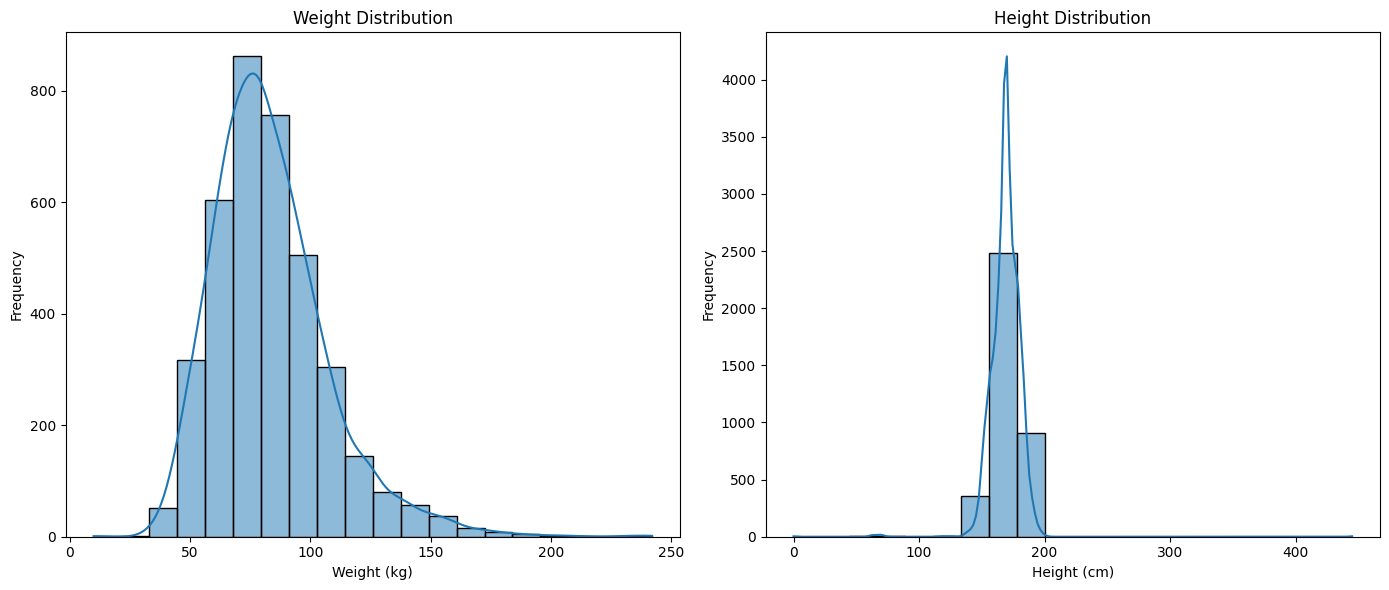

In [ ]:
# Plotting distributions
plt.figure(figsize=(14, 6))

# Weight distribution
plt.subplot(1, 2, 1)
sns.histplot(train_static['weight'], kde=True, bins=20)
plt.title('Weight Distribution')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')

# Height distribution
plt.subplot(1, 2, 2)
sns.histplot(train_static['height'], kde=True, bins=20)
plt.title('Height Distribution')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Any infinity BMI values indicate that the height for some patients must be 0.

In this instance, the value for those heights will be set to the average height across patients and the BMI recalculated.

# **Removing Outliers for numerical data**

MIMIC does not ascribe a high and low normal value for weight and height.

First we will try mean +/- 3std and see what the lower and upper bounds are.

In [ ]:
# Function to calculate mean and standard deviation of specified column in a dataframe
def calculate_mean_std(df, column):
    mean = df[column].mean()
    std = df[column].std()
    return mean, std

In [ ]:
weight_mean, weight_std = calculate_mean_std(train_static, 'weight')
height_mean, height_std = calculate_mean_std(train_static, 'height')

print(f"Weight lower bound: {weight_mean - 3 * weight_std}")
print(f"Weight upper bound: {weight_mean + 3 * weight_std}")

print(f"Height lower bound: {height_mean - 3 * height_std}")
print(f"Height upper bound: {height_mean + 3 * height_std}")

Weight lower bound: 10.666882773884595
Weight upper bound: 156.29838318356218
Height lower bound: 132.50146850877465
Height upper bound: 205.62312976069384


The bounds seem reasonable for the height but having a lower bound on the weight of approx 10kg is quite low. Also having a height upper bound larger than what seems to be the max height of 200cm does not make sense.

Now we will try Interquartile range as a bounding technique and see what values that shows.

In [ ]:
# Function to calculate IQR bounds
def calculate_iqr_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [ ]:
weight_lower, weight_upper = calculate_iqr_bounds(train_static, 'weight')
height_lower, height_upper = calculate_iqr_bounds(train_static, 'height')

print(f"Weight lower bound: {weight_lower}")
print(f"Weight upper bound: {weight_upper}")

print(f"Height lower bound: {height_lower}")
print(f"Height upper bound: {height_upper}")

Weight lower bound: 23.949999999999996
Weight upper bound: 138.75
Height lower bound: 145.0
Height upper bound: 193.0


**Decision - we will use the IQR range to remove numerical outliers in the weight and height**

The range here is more reasonable so will be employed.

We will set the heights and weights of any patient outside these ranges to NaN and fill with the mean.

We will then recalulate the BMI based on the new heights and widths.

In [ ]:
train_static = train_static_copy.copy()
test_static = test_static_copy.copy()

# Identify the minimum value for each numerical feature
min_values = train_static[numerical_features].min()

print(min_values)

weight    10.000000
height     0.000000
BMI        3.498698
dtype: float64


We need to make sure we are calculating the bounds only based on the training data and then applying those bounds to both the train and test data.

In [ ]:
# Calculate the bounds for the training data
train_weight_lower, train_weight_upper = calculate_iqr_bounds(train_static, 'weight')
train_height_lower, train_height_upper = calculate_iqr_bounds(train_static, 'height')

print(f"Train weight lower bound: {train_weight_lower}")
print(f"Train weight upper bound: {train_weight_upper}")

print(f"Train height lower bound: {train_height_lower}")
print(f"Train height upper bound: {train_height_upper}")

Train weight lower bound: 23.949999999999996
Train weight upper bound: 138.75
Train height lower bound: 145.0
Train height upper bound: 193.0


In [ ]:
# Apply the IQR upper and lower bounds and assign the heights anf weights of the patients outside the range to NaN and replace with the mean

# Function to replace outliers with NaN based on the train bounds defined
def replace_outliers_with_nan(df, column, lower_bound, upper_bound):
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = np.nan


In [ ]:
# Replace weight outliers based on training bounds with NaN
replace_outliers_with_nan(train_static, 'weight', train_weight_lower, train_weight_upper)
replace_outliers_with_nan(test_static, 'weight', train_weight_lower, train_weight_upper)

# Replace height outliers based on training bound with NaN
replace_outliers_with_nan(train_static, 'height', train_height_lower, train_height_upper)
replace_outliers_with_nan(test_static, 'height', train_height_lower, train_height_upper)

# Count the number of NaNs
print(f"Train weight NaN count: {train_static['weight'].isna().sum()}")
print(f"Train height NaN count: {train_static['height'].isna().sum()}")
print(f"Test Weight NaN count: {test_static['weight'].isna().sum()}")
print(f"Test Height NaN count: {test_static['height'].isna().sum()}")

Train weight NaN count: 118
Train height NaN count: 44
Test Weight NaN count: 24
Test Height NaN count: 9


We will then need to replace the NaN value with the mean value of the population.

To avoid data leakage, **we will replace both train and test NaN values with the means calculated only using the training set**.

In [ ]:
# Calculate the mean of the training set
train_weight_mean = train_static['weight'].mean()
train_height_mean = train_static['height'].mean()

print(f"Train weight mean: {train_weight_mean}")
print(f"Train height mean: {train_height_mean}")

Train weight mean: 81.09678747940691
Train height mean: 169.37051796194856


In [ ]:
# Replace NaNs in the train and test set with the train means
train_static['weight'].fillna(train_weight_mean, inplace=True)
train_static['height'].fillna(train_height_mean, inplace=True)

test_static['weight'].fillna(train_weight_mean, inplace=True)
test_static['height'].fillna(train_height_mean, inplace=True)

# Count the number of NaNs
print(f"Train weight NaN count: {train_static['weight'].isna().sum()}")
print(f"Train height NaN count: {train_static['height'].isna().sum()}")
print(f"Test Weight NaN count: {test_static['weight'].isna().sum()}")
print(f"Test Height NaN count: {test_static['height'].isna().sum()}")

Train weight NaN count: 0
Train height NaN count: 0
Test Weight NaN count: 0
Test Height NaN count: 0


Now we can recalculate the BMI column

In [ ]:
# Recalculate the BMI column
train_static['BMI'] = train_static['weight'] / ((train_static['height'] / 100) ** 2)
test_static['BMI'] = test_static['weight'] / ((test_static['height'] / 100) ** 2)

min_values = test_static[numerical_features].min()

print(min_values)

weight     36.400000
height    147.000000
BMI        14.139629
dtype: float64


In [ ]:
# Save progress so far
train_static.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/raw_data/train_static_no_outliers_v3.parquet')
test_static.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/raw_data/test_static_no_outliers_v3.parquet')

In [ ]:
# Count the number of subject ids
train_static['subject_id'].nunique(), test_static['subject_id'].nunique()

(3760, 941)

In [ ]:
train_static_copy_2 = train_static.copy()
test_static_copy_2 = test_static.copy()

In [ ]:
min_values = train_static[numerical_features].min()

print(min_values)

weight     32.300000
height    145.000000
BMI        11.259702
dtype: float64


In [ ]:
max_values = train_static[numerical_features].max()

print(max_values)

weight    138.700000
height    193.000000
BMI        56.026614
dtype: float64


## **Scaling the data**

Now the values are in a more reasonable range, we can scale them using the MinMax scaler which is prefereable for LSTM.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [ ]:
train_static = train_static_copy_2.copy()
test_static = test_static_copy_2.copy()

train_static.head()

,subject_id,age,gender,ethnicity,weight,height,BMI
0,10001884,68,F,BLACK/AFRICAN AMERICAN,65.0,157.0,26.370238
22,10002428,80,F,WHITE,43.0,150.0,19.111111
29,10004235,47,M,BLACK/CAPE VERDEAN,127.0,183.0,37.922900
32,10010867,28,F,WHITE - BRAZILIAN,120.0,170.0,41.522491
35,10011365,73,F,WHITE,46.3,157.0,18.783723


In [ ]:
# Only scale weight and height
scaler = MinMaxScaler()

# Scale weight, height and BMI
train_static[['weight', 'height', 'BMI']] = scaler.fit_transform(train_static[['weight', 'height', 'BMI']])

test_static[['weight', 'height', 'BMI']] = scaler.transform(test_static[['weight', 'height', 'BMI']])

train_static.head()

,subject_id,age,gender,ethnicity,weight,height,BMI
0,10001884,68,F,BLACK/AFRICAN AMERICAN,0.307331,0.250000,0.337538
22,10002428,80,F,WHITE,0.100564,0.104167,0.175384
29,10004235,47,M,BLACK/CAPE VERDEAN,0.890038,0.791667,0.595601
32,10010867,28,F,WHITE - BRAZILIAN,0.824248,0.520833,0.676008
35,10011365,73,F,WHITE,0.131579,0.250000,0.168071


In [ ]:
# Save progress so far
train_static.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/raw_data/train_static_scaled_v3.parquet')
test_static.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/raw_data/test_static_scaled_v3.parquet')

In [ ]:
train_static_copy_3 = train_static.copy()
test_static_copy_3 = test_static.copy()

In [ ]:
# Load train and test static
train_static = pd.read_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/raw_data/train_static_scaled.parquet')
test_static = pd.read_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/raw_data/test_static_scaled.parquet')

train_static.head()

,subject_id,age,gender,ethnicity,weight,height,BMI
0,10001884,68,F,BLACK/AFRICAN AMERICAN,0.305322,0.250000,0.309554
22,10002428,80,F,WHITE,0.099907,0.104167,0.160855
29,10004235,47,M,BLACK/CAPE VERDEAN,0.884220,0.791667,0.546203
32,10004720,61,M,WHITE,0.352007,0.791667,0.197548
33,10004733,51,M,OTHER,0.748833,0.729167,0.480639


# **Categorical Data**

We need to categorise Age into the relevant buckets defined by the Apache Score.

Then we can OneHotEncode age, gender and ethnicity.

As discussed with Mayur we will use the exemplar age categories used by the ICNARC (Intensive Care National Audit Research Centre) in their studies.

In the paper (https://www.ncbi.nlm.nih.gov/books/NBK321618/), the APACHE model is outlined (often used in ICUs for mortality assesments).

In this paper the age categories of ≤ 44, 45–54, 55–64, 65–74 or ≥ 75 years were used and these will be used in this study as well.




In [ ]:
# Define the age categories
bins = [0, 44, 54, 64, 74, float('inf')]
labels = ['≤44', '45-54', '55-64', '65-74', '≥75']

In [ ]:
train_static['age_group'] = pd.cut(train_static['age'], bins=bins, labels=labels, right=False)

test_static['age_group'] = pd.cut(test_static['age'], bins=bins, labels=labels, right=False)

train_static.head()

,subject_id,age,gender,ethnicity,weight,height,BMI,age_group
0,10001884,68,F,BLACK/AFRICAN AMERICAN,0.307331,0.250000,0.337538,65-74
22,10002428,80,F,WHITE,0.100564,0.104167,0.175384,≥75
29,10004235,47,M,BLACK/CAPE VERDEAN,0.890038,0.791667,0.595601,45-54
32,10010867,28,F,WHITE - BRAZILIAN,0.824248,0.520833,0.676008,≤44
35,10011365,73,F,WHITE,0.131579,0.250000,0.168071,65-74


In [ ]:
# Drop the age column
train_static.drop('age', axis=1, inplace=True)

test_static.drop('age', axis=1, inplace=True)

train_static.head()

,subject_id,gender,ethnicity,weight,height,BMI,age_group
0,10001884,F,BLACK/AFRICAN AMERICAN,0.307331,0.250000,0.337538,65-74
22,10002428,F,WHITE,0.100564,0.104167,0.175384,≥75
29,10004235,M,BLACK/CAPE VERDEAN,0.890038,0.791667,0.595601,45-54
32,10010867,F,WHITE - BRAZILIAN,0.824248,0.520833,0.676008,≤44
35,10011365,F,WHITE,0.131579,0.250000,0.168071,65-74


Now we can OneHotEncode the categorical features: Gender, Ethnicity and Age group

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
categorical_features = ['age_group', 'gender', 'ethnicity']

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Encode categorical features
train_static_encoded = pd.DataFrame(encoder.fit_transform(train_static[categorical_features]))

test_static_encoded = pd.DataFrame(encoder.transform(test_static[categorical_features]))

train_static_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Assign cases where ethnicity = 'HISPANIC/LATINO - CENTRAL AMERICAN' to the 'OTHER' class
train_static.loc[train_static['ethnicity'] == 'HISPANIC/LATINO - CENTRAL AMERICAN', 'ethnicity'] = 'OTHER'
test_static.loc[test_static['ethnicity'] == 'HISPANIC/LATINO - CENTRAL AMERICAN', 'ethnicity'] = 'OTHER'

# List the unique ethnicity
train_static['ethnicity'].unique()

array(['BLACK/AFRICAN AMERICAN', 'WHITE', 'BLACK/CAPE VERDEAN',
       'WHITE - BRAZILIAN', 'OTHER', 'HISPANIC OR LATINO',
       'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - PUERTO RICAN',
       'ASIAN - CHINESE', 'WHITE - OTHER EUROPEAN', 'ASIAN',
       'BLACK/AFRICAN', 'WHITE - RUSSIAN', 'ASIAN - SOUTH EAST ASIAN',
       'MULTIPLE RACE/ETHNICITY', 'HISPANIC/LATINO - HONDURAN',
       'BLACK/CARIBBEAN ISLAND', 'ASIAN - KOREAN',
       'WHITE - EASTERN EUROPEAN',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'SOUTH AMERICAN',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - ASIAN INDIAN',
       'AMERICAN INDIAN/ALASKA NATIVE', 'HISPANIC/LATINO - COLUMBIAN',
       'PORTUGUESE', 'HISPANIC/LATINO - MEXICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - CUBAN'],
      dtype=object)

In [ ]:
# Check for NaN values
train_static.isnull().sum()

subject_id    0
gender        0
ethnicity     0
weight        0
height        0
BMI           0
age_group     0
dtype: int64

In [ ]:
# Now we can encode
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Encode categorical features
train_static_encoded = pd.DataFrame(encoder.fit_transform(train_static[categorical_features]))

test_static_encoded = pd.DataFrame(encoder.transform(test_static[categorical_features]))

train_static_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
train_static_encoded.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760 entries, 0 to 3759
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3760 non-null   float64
 1   1       3760 non-null   float64
 2   2       3760 non-null   float64
 3   3       3760 non-null   float64
 4   4       3760 non-null   float64
 5   5       3760 non-null   float64
 6   6       3760 non-null   float64
 7   7       3760 non-null   float64
 8   8       3760 non-null   float64
 9   9       3760 non-null   float64
 10  10      3760 non-null   float64
 11  11      3760 non-null   float64
 12  12      3760 non-null   float64
 13  13      3760 non-null   float64
 14  14      3760 non-null   float64
 15  15      3760 non-null   float64
 16  16      3760 non-null   float64
 17  17      3760 non-null   float64
 18  18      3760 non-null   float64
 19  19      3760 non-null   float64
 20  20      3760 non-null   float64
 21  21      3760 non-null   float64
 22  

In [ ]:
# Get the feature names out for more relevant columns
train_static_encoded.columns = encoder.get_feature_names_out(categorical_features)

test_static_encoded.columns = encoder.get_feature_names_out(categorical_features)

train_static_encoded.head()

,age_group_55-64,age_group_65-74,age_group_≤44,age_group_≥75,gender_M,ethnicity_ASIAN,ethnicity_ASIAN - ASIAN INDIAN,ethnicity_ASIAN - CHINESE,ethnicity_ASIAN - KOREAN,ethnicity_ASIAN - SOUTH EAST ASIAN,...,ethnicity_MULTIPLE RACE/ETHNICITY,ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_OTHER,ethnicity_PORTUGUESE,ethnicity_SOUTH AMERICAN,ethnicity_WHITE,ethnicity_WHITE - BRAZILIAN,ethnicity_WHITE - EASTERN EUROPEAN,ethnicity_WHITE - OTHER EUROPEAN,ethnicity_WHITE - RUSSIAN
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
train_static_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760 entries, 0 to 3759
Data columns (total 33 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   age_group_55-64                                      3760 non-null   float64
 1   age_group_65-74                                      3760 non-null   float64
 2   age_group_≤44                                        3760 non-null   float64
 3   age_group_≥75                                        3760 non-null   float64
 4   gender_M                                             3760 non-null   float64
 5   ethnicity_ASIAN                                      3760 non-null   float64
 6   ethnicity_ASIAN - ASIAN INDIAN                       3760 non-null   float64
 7   ethnicity_ASIAN - CHINESE                            3760 non-null   float64
 8   ethnicity_ASIAN - KOREAN                             3760 non-null  

In [ ]:
train_static_encoded_copy = train_static_encoded.copy()
test_static_encoded_copy = test_static_encoded.copy()

In [ ]:
# Combine numerical and encoded categorical features and subject_id
train_combined = pd.concat([train_static[['subject_id'] + numerical_features].reset_index(drop=True), train_static_encoded.reset_index(drop=True)], axis=1)

test_combined = pd.concat([test_static[['subject_id'] + numerical_features].reset_index(drop=True), test_static_encoded.reset_index(drop=True)], axis=1)

train_combined.shape, test_combined.shape

((3760, 37), (941, 37))

In [ ]:
test_combined.head()

,subject_id,weight,height,BMI,age_group_55-64,age_group_65-74,age_group_≤44,age_group_≥75,gender_M,ethnicity_ASIAN,...,ethnicity_MULTIPLE RACE/ETHNICITY,ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_OTHER,ethnicity_PORTUGUESE,ethnicity_SOUTH AMERICAN,ethnicity_WHITE,ethnicity_WHITE - BRAZILIAN,ethnicity_WHITE - EASTERN EUROPEAN,ethnicity_WHITE - OTHER EUROPEAN,ethnicity_WHITE - RUSSIAN
0,10004720,0.354323,0.791667,0.215398,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10004733,0.753759,0.729167,0.524104,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10005817,0.551692,0.583333,0.427673,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,10013643,0.320489,0.515569,0.263242,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,10022620,0.222744,0.479167,0.191694,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Save this as the final static data set for feature set 1 for all patientes
train_combined.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_static_final_v2.parquet')
test_combined.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/test_static_final_v2.parquet')


In [ ]:
output_dir = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data'

In [ ]:
np.save(output_dir + '/train_combined_v2.npy', train_combined.values)
np.save(output_dir + '/test_combined_v2.npy', test_combined.values)

**Repated static features so they are available in each time step.**

**WE CHOSE NOT TO PURSUE THIS FURTHER AND HAVE LSTM-FFNN SEPARATE**

LSTM data requires a value to be present for each time point so the data needs to be repeated for each sequence.

We have a sequence length of 13 for every 30 mins in the 6 hour time window.


# **Addendum - Categorise Ethnicity**

To reduce dimensionality and try and imporve model performance for the static data we are going to categorise the ethnicity data into broader categories.

In [ ]:
train_static = train_combined.copy()
test_static = test_combined.copy()

In [ ]:
# Load the static data
train_static = pd.read_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_static_final_v2.parquet')
test_static = pd.read_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/test_static_final_v2.parquet')

train_static.head()

,subject_id,weight,height,BMI,age_group_55-64,age_group_65-74,age_group_≤44,age_group_≥75,gender_M,ethnicity_ASIAN,...,ethnicity_MULTIPLE RACE/ETHNICITY,ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ethnicity_OTHER,ethnicity_PORTUGUESE,ethnicity_SOUTH AMERICAN,ethnicity_WHITE,ethnicity_WHITE - BRAZILIAN,ethnicity_WHITE - EASTERN EUROPEAN,ethnicity_WHITE - OTHER EUROPEAN,ethnicity_WHITE - RUSSIAN
0,10001884,0.307331,0.250000,0.337538,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10002428,0.100564,0.104167,0.175384,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,10004235,0.890038,0.791667,0.595601,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10010867,0.824248,0.520833,0.676008,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,10011365,0.131579,0.250000,0.168071,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Create a list of all the columns starting with 'ethnicity'
ethnicity_columns = [col for col in train_static.columns if col.startswith('ethnicity')]

# Print the list of ethnicity columns
print(ethnicity_columns)

['ethnicity_ASIAN', 'ethnicity_ASIAN - ASIAN INDIAN', 'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - KOREAN', 'ethnicity_ASIAN - SOUTH EAST ASIAN', 'ethnicity_BLACK/AFRICAN', 'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_BLACK/CAPE VERDEAN', 'ethnicity_BLACK/CARIBBEAN ISLAND', 'ethnicity_HISPANIC OR LATINO', 'ethnicity_HISPANIC/LATINO - COLUMBIAN', 'ethnicity_HISPANIC/LATINO - CUBAN', 'ethnicity_HISPANIC/LATINO - DOMINICAN', 'ethnicity_HISPANIC/LATINO - GUATEMALAN', 'ethnicity_HISPANIC/LATINO - HONDURAN', 'ethnicity_HISPANIC/LATINO - MEXICAN', 'ethnicity_HISPANIC/LATINO - PUERTO RICAN', 'ethnicity_HISPANIC/LATINO - SALVADORAN', 'ethnicity_MULTIPLE RACE/ETHNICITY', 'ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ethnicity_OTHER', 'ethnicity_PORTUGUESE', 'ethnicity_SOUTH AMERICAN', 'ethnicity_WHITE', 'ethnicity_WHITE - BRAZILIAN', 'ethnicity_WHITE - EASTERN EUROPEAN', 'ethnicity_WHITE - OTHER EUROPEAN', 'ethnicity_WHITE - RUSSIAN']


In [ ]:
# Count the number of patients in each ethnicity
ethnicity_counts = train_static[ethnicity_columns].sum()

print(ethnicity_counts)

ethnicity_ASIAN                                          39.0
ethnicity_ASIAN - ASIAN INDIAN                            8.0
ethnicity_ASIAN - CHINESE                                29.0
ethnicity_ASIAN - KOREAN                                  4.0
ethnicity_ASIAN - SOUTH EAST ASIAN                       12.0
ethnicity_BLACK/AFRICAN                                  13.0
ethnicity_BLACK/AFRICAN AMERICAN                        310.0
ethnicity_BLACK/CAPE VERDEAN                             27.0
ethnicity_BLACK/CARIBBEAN ISLAND                         20.0
ethnicity_HISPANIC OR LATINO                             36.0
ethnicity_HISPANIC/LATINO - COLUMBIAN                     1.0
ethnicity_HISPANIC/LATINO - CUBAN                         2.0
ethnicity_HISPANIC/LATINO - DOMINICAN                    37.0
ethnicity_HISPANIC/LATINO - GUATEMALAN                   10.0
ethnicity_HISPANIC/LATINO - HONDURAN                      4.0
ethnicity_HISPANIC/LATINO - MEXICAN                       2.0
ethnicit

Asian, Black, Hispanic, White, Other will be our compiled categories.

In [ ]:
train_static_copy = train_static.copy()
test_static_copy = test_static.copy()

In [ ]:
def map_and_categorize_ethnicities(df, ethnicity_columns):
    # Define the mapping to broader categories
    def map_ethnicity_to_broad_category(col_name):
        if 'ASIAN' in col_name:
            return 'ethnicity_ASIAN'
        elif 'BLACK' in col_name:
            return 'ethnicity_BLACK'
        elif 'HISPANIC' in col_name:
            return 'ethnicity_HISPANIC'
        elif 'WHITE' in col_name:
            return 'ethnicity_WHITE'
        else:
            return 'ethnicity_OTHER'

    # Initialize the new columns for broader categories
    broad_categories = ['ethnicity_ASIAN', 'ethnicity_BLACK', 'ethnicity_HISPANIC', 'ethnicity_WHITE', 'ethnicity_OTHER']
    for category in broad_categories:
        df[category] = 0.0

    # Map the detailed ethnicity columns to broader categories
    for col in ethnicity_columns:
        if col in df.columns:
            broad_category = map_ethnicity_to_broad_category(col)
            df[broad_category] = df[broad_category] + df[col].astype(float)

    # Ensure that the values are binary (0 or 1)
    for category in broad_categories:
        df[category] = df[category].apply(lambda x: 1.0 if x > 0 else 0.0)

    # Ensure that each patient is represented by only one broader category
    df['ethnicity_broad'] = df[broad_categories].idxmax(axis=1)

    # One-hot encode the new broad category
    df = pd.get_dummies(df, columns=['ethnicity_broad'])

    # Rename the columns to match the desired format
    df = df.rename(columns=lambda x: x.replace('ethnicity_broad_', 'ethnicity_'))

    # Drop the original detailed ethnicity columns
    df = df.drop(columns=ethnicity_columns)

    return df

In [ ]:
print(train_static_copy.columns)

Index(['subject_id', 'weight', 'height', 'BMI', 'age_group_55-64',
       'age_group_65-74', 'age_group_≤44', 'age_group_≥75', 'gender_M',
       'ethnicity_ASIAN', 'ethnicity_ASIAN - ASIAN INDIAN',
       'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - KOREAN',
       'ethnicity_ASIAN - SOUTH EAST ASIAN', 'ethnicity_BLACK/AFRICAN',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_BLACK/CAPE VERDEAN',
       'ethnicity_BLACK/CARIBBEAN ISLAND', 'ethnicity_HISPANIC OR LATINO',
       'ethnicity_HISPANIC/LATINO - COLUMBIAN',
       'ethnicity_HISPANIC/LATINO - CUBAN',
       'ethnicity_HISPANIC/LATINO - DOMINICAN',
       'ethnicity_HISPANIC/LATINO - GUATEMALAN',
       'ethnicity_HISPANIC/LATINO - HONDURAN',
       'ethnicity_HISPANIC/LATINO - MEXICAN',
       'ethnicity_HISPANIC/LATINO - PUERTO RICAN',
       'ethnicity_HISPANIC/LATINO - SALVADORAN',
       'ethnicity_MULTIPLE RACE/ETHNICITY',
       'ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'ethnicity_OTHER', '

In [ ]:
train_static_categorised = map_and_categorize_ethnicities(train_static_copy, ethnicity_columns)
test_static_categorised = map_and_categorize_ethnicities(test_static_copy, ethnicity_columns)

train_static_categorised.head()

,subject_id,weight,height,BMI,age_group_55-64,age_group_65-74,age_group_≤44,age_group_≥75,gender_M,ethnicity_BLACK,ethnicity_HISPANIC,ethnicity_ethnicity_ASIAN,ethnicity_ethnicity_BLACK,ethnicity_ethnicity_HISPANIC,ethnicity_ethnicity_OTHER,ethnicity_ethnicity_WHITE
0,10001884,0.307331,0.250000,0.337538,0.0,1.0,0.0,0.0,0.0,1.0,0.0,False,True,False,False,False
1,10002428,0.100564,0.104167,0.175384,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,False,False,False,False
2,10004235,0.890038,0.791667,0.595601,0.0,0.0,0.0,0.0,1.0,1.0,0.0,False,True,False,False,False
3,10010867,0.824248,0.520833,0.676008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False,False,False,False,True
4,10011365,0.131579,0.250000,0.168071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False,False


In [ ]:
test_static_categorised.head()

,subject_id,weight,height,BMI,age_group_55-64,age_group_65-74,age_group_≤44,age_group_≥75,gender_M,ethnicity_BLACK,ethnicity_HISPANIC,ethnicity_ethnicity_ASIAN,ethnicity_ethnicity_BLACK,ethnicity_ethnicity_HISPANIC,ethnicity_ethnicity_OTHER,ethnicity_ethnicity_WHITE
0,10004720,0.354323,0.791667,0.215398,1.0,0.0,0.0,0.0,1.0,0.0,0.0,True,False,False,False,False
1,10004733,0.753759,0.729167,0.524104,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,False,False,False,False
2,10005817,0.551692,0.583333,0.427673,0.0,1.0,0.0,0.0,1.0,0.0,0.0,True,False,False,False,False
3,10013643,0.320489,0.515569,0.263242,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,False,False,False,False
4,10022620,0.222744,0.479167,0.191694,0.0,0.0,1.0,0.0,1.0,0.0,0.0,True,False,False,False,False


In [ ]:
# Drop ethnicity_BLACK	ethnicity_HISPANIC columns
train_static_categorised.drop(['ethnicity_BLACK', 'ethnicity_HISPANIC'], axis=1, inplace=True)
test_static_categorised.drop(['ethnicity_BLACK', 'ethnicity_HISPANIC'], axis=1, inplace=True)

train_static_categorised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760 entries, 0 to 3759
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subject_id                    3760 non-null   int64  
 1   weight                        3760 non-null   float64
 2   height                        3760 non-null   float64
 3   BMI                           3760 non-null   float64
 4   age_group_55-64               3760 non-null   float64
 5   age_group_65-74               3760 non-null   float64
 6   age_group_≤44                 3760 non-null   float64
 7   age_group_≥75                 3760 non-null   float64
 8   gender_M                      3760 non-null   float64
 9   ethnicity_ethnicity_ASIAN     3760 non-null   bool   
 10  ethnicity_ethnicity_BLACK     3760 non-null   bool   
 11  ethnicity_ethnicity_HISPANIC  3760 non-null   bool   
 12  ethnicity_ethnicity_OTHER     3760 non-null   bool   
 13  eth

In [ ]:
# Convert all ethnicity columns to 1.0 or 0.0 instead of bool
ethnicity_columns = [col for col in train_static_categorised.columns if col.startswith('ethnicity_')]

train_static_categorised[ethnicity_columns] = train_static_categorised[ethnicity_columns].astype(float)
test_static_categorised[ethnicity_columns] = test_static_categorised[ethnicity_columns].astype(float)

train_static_categorised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760 entries, 0 to 3759
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subject_id                    3760 non-null   int64  
 1   weight                        3760 non-null   float64
 2   height                        3760 non-null   float64
 3   BMI                           3760 non-null   float64
 4   age_group_55-64               3760 non-null   float64
 5   age_group_65-74               3760 non-null   float64
 6   age_group_≤44                 3760 non-null   float64
 7   age_group_≥75                 3760 non-null   float64
 8   gender_M                      3760 non-null   float64
 9   ethnicity_ethnicity_ASIAN     3760 non-null   float64
 10  ethnicity_ethnicity_BLACK     3760 non-null   float64
 11  ethnicity_ethnicity_HISPANIC  3760 non-null   float64
 12  ethnicity_ethnicity_OTHER     3760 non-null   float64
 13  eth

In [ ]:
train_static_categorised.head()

,subject_id,weight,height,BMI,age_group_55-64,age_group_65-74,age_group_≤44,age_group_≥75,gender_M,ethnicity_ethnicity_ASIAN,ethnicity_ethnicity_BLACK,ethnicity_ethnicity_HISPANIC,ethnicity_ethnicity_OTHER,ethnicity_ethnicity_WHITE
0,10001884,0.307331,0.250000,0.337538,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,10002428,0.100564,0.104167,0.175384,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,10004235,0.890038,0.791667,0.595601,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,10010867,0.824248,0.520833,0.676008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,10011365,0.131579,0.250000,0.168071,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Remove the first ethnicity_ from the ethnicity columns
train_static_categorised.columns = train_static_categorised.columns.str.replace('ethnicity_', '')
test_static_categorised.columns = test_static_categorised.columns.str.replace('ethnicity_', '')

train_static_categorised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760 entries, 0 to 3759
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject_id       3760 non-null   int64  
 1   weight           3760 non-null   float64
 2   height           3760 non-null   float64
 3   BMI              3760 non-null   float64
 4   age_group_55-64  3760 non-null   float64
 5   age_group_65-74  3760 non-null   float64
 6   age_group_≤44    3760 non-null   float64
 7   age_group_≥75    3760 non-null   float64
 8   gender_M         3760 non-null   float64
 9   ASIAN            3760 non-null   float64
 10  BLACK            3760 non-null   float64
 11  HISPANIC         3760 non-null   float64
 12  OTHER            3760 non-null   float64
 13  WHITE            3760 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 411.4 KB


In [ ]:
# Add ethnicity_ to the front of the column names of the last 5 columns
ethnicity_columns = train_static_categorised.columns[-5:]
train_static_categorised.rename(columns=dict(zip(ethnicity_columns, ['ethnicity_' + col for col in ethnicity_columns])), inplace=True)
test_static_categorised.rename(columns=dict(zip(ethnicity_columns, ['ethnicity_' + col for col in ethnicity_columns])), inplace=True)

train_static_categorised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760 entries, 0 to 3759
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subject_id          3760 non-null   int64  
 1   weight              3760 non-null   float64
 2   height              3760 non-null   float64
 3   BMI                 3760 non-null   float64
 4   age_group_55-64     3760 non-null   float64
 5   age_group_65-74     3760 non-null   float64
 6   age_group_≤44       3760 non-null   float64
 7   age_group_≥75       3760 non-null   float64
 8   gender_M            3760 non-null   float64
 9   ethnicity_ASIAN     3760 non-null   float64
 10  ethnicity_BLACK     3760 non-null   float64
 11  ethnicity_HISPANIC  3760 non-null   float64
 12  ethnicity_OTHER     3760 non-null   float64
 13  ethnicity_WHITE     3760 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 411.4 KB


In [ ]:
train_static_categorised.head()

,subject_id,weight,height,BMI,age_group_55-64,age_group_65-74,age_group_≤44,age_group_≥75,gender_M,ethnicity_ASIAN,ethnicity_BLACK,ethnicity_HISPANIC,ethnicity_OTHER,ethnicity_WHITE
0,10001884,0.307331,0.250000,0.337538,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,10002428,0.100564,0.104167,0.175384,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,10004235,0.890038,0.791667,0.595601,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,10010867,0.824248,0.520833,0.676008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,10011365,0.131579,0.250000,0.168071,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Check that no row has a sum greater than 1 for the last 5 columns
assert (train_static_categorised.iloc[:, -5:].sum(axis=1) <= 1).all()
assert (test_static_categorised.iloc[:, -5:].sum(axis=1) <= 1).all()

In [ ]:
# Save the data as the final static data
train_static_categorised.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_static_v4.parquet')
test_static_categorised.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/test_static_v4.parquet')

In [ ]:
# Save as .npy files
output_dir = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data'

np.save(output_dir + '/train_static_v4.npy', train_static_categorised.values)
np.save(output_dir + '/test_static_v4.npy', test_static_categorised.values)

In [ ]:
train_static_categorised.shape, test_static_categorised.shape

((3760, 14), (941, 14))

In [ ]:
train_static_categorised.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_static.parquet')
test_static_categorised.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/test_static.parquet')
#